# **IMPORT LIBRARY**


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, resnet34, googlenet
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2
import time
from torch.autograd import Variable
import joblib
import seaborn as sns

In [2]:
use_gpu = torch.cuda.is_available()

# **DATA PREPARATION**

In [3]:
data_path='/kaggle/input/gender/Dataset-Gender/Dataset'
project_path='/kaggle/input/gender'

attribute_path = data_path+'/list_attribute.txt'
image_list_path = data_path+'/Images'

In [4]:
os.listdir(data_path)

['gender_classification.xlsx',
 'list_attribute.txt',
 'gender_classification.csv',
 'Images',
 'model_saved',
 'class_identity.txt']

In [5]:
images = os.listdir(image_list_path)
images = [image for image in images if len(image.split('(')) <= 1]
print('Eg: ', images[:2])
print('Count:', len(images))
# images

Eg:  ['168180.jpg', '012764.jpg']
Count: 5000


In [6]:
data = pd.DataFrame(pd.read_csv(project_path+'/cleaned_list_attribute.txt', sep='\s+'))
data = pd.DataFrame(data.filter(items=images, axis=0))
data = data.replace(-1, 0)
data = data['Male']

In [7]:
data.info()

<class 'pandas.core.series.Series'>
Index: 5000 entries, 168180.jpg to 091184.jpg
Series name: Male
Non-Null Count  Dtype
--------------  -----
5000 non-null   int64
dtypes: int64(1)
memory usage: 78.1+ KB


In [8]:
# Redistribute male & female image
data_male = data[data==1]
data_female = data[data==0]

train_data = pd.concat([data_male[:1500], data_female[:1500]], axis=0)
test_data = pd.concat([data_male[1500:], data_female[1500:]], axis=0)

## **HELPERS**

In [9]:
def dataset_getitem(image_folder_path, data, idx):
  image_name = data.keys()[idx]
  gender = data.iloc[idx]

  image_path = os.path.join(image_folder_path, image_name)
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = Image.fromarray(image)

  return {
      'image': image,
      'gender': gender,
  }

# Function Sample
dataset_getitem(os.path.join(data_path, "Images"), train_data, 0)

{'image': <PIL.Image.Image image mode=RGB size=178x218>, 'gender': 1}

In [10]:
def get_report(model, test_dataloaders):
    train_time = 0
    y_true = torch.empty((0)).cuda()
    y_pred = torch.empty((0)).cuda()

    for data in test_dataloaders:
      inputs, labels = data
      
      if torch.cuda.is_available():
          inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      else:
          inputs, labels = Variable(inputs), Variable(labels)
      
      start_time = time.time()
      outputs = model(inputs)
    
      end_time = time.time()
      train_time += end_time - start_time
     
      preds = (torch.sigmoid(outputs).squeeze() > 0.5).float()
      y_true = torch.cat((y_true, labels.data), -1)
      y_pred = torch.cat((y_pred, preds), -1)
    
    inference_time = train_time/len(test_dataloaders)
    
    return y_true, y_pred, inference_time

In [11]:
def plot_train(loss, train_acc, val_acc):
    x = np.arange(0,10,1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(x, train_acc, color='r', label='train acc')
    ax[0].plot(x, val_acc, color='b', label='val acc')
    ax[0].set_xlabel("Epoch(s)") 
    ax[0].set_ylabel("Accuracy") 
    ax[0].set_title("Accuracy per epoch")
    ax[0].legend()

    ax[1].plot(x, loss, color='r', label='loss')
    ax[1].set_xlabel("Epoch(s)") 
    ax[1].set_ylabel("Loss") 
    ax[1].set_title("Loss per epoch")
    ax[1].legend()

    plt.show

# **DATA PRE-PROCESSING**

In [12]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      result = dataset_getitem(self.image_folder_path, self.data, idx)
      if self.transform:
        image = self.transform(result['image'])
      return image, torch.tensor(result['gender'], dtype=torch.long)

In [13]:
transform = {
     'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform['train'])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform['test'])
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

print({ 'train': len(train_set), 'test': len(test_set) })

{'train': 3000, 'test': 2000}


In [15]:
dataloders = {"train":train_loader, "test":test_loader}
dataset_sizes = {"train":len(train_set), "test":len(test_set)}

In [16]:
criterion = nn.BCEWithLogitsLoss()

# **MODEL RESNET**

In [17]:
def train_model_resnet(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels.float())

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                preds = (torch.sigmoid(outputs) > 0.5).float()
#                 print('preds {}'.format(preds))
                running_loss += loss.data
#                 print('running_loss {}'.format(running_loss))
                running_corrects += torch.sum(preds == labels.data)
#                 print('running_corrects {}'.format(running_corrects))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
#                 torch.save(state,'/kaggle/working/resnet18.pth')
                joblib.dump(state, '/kaggle/working/resnet18_compressed.pkl', compress=3)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## **MODEL RESNET18**

In [18]:
model_r18 = resnet18()
num_features = model_r18.fc.in_features
model_r18.fc = nn.Linear(num_features, 1)
optimizer_r18 = optim.Adam(model_r18.parameters(), lr=0.0001)

if use_gpu:
    model_r18 = model_r18.cuda()

In [19]:
model_r18 = train_model_resnet(model_r18, dataloders, dataset_sizes, criterion, optimizer_r18)

Epoch 0/9
----------
train Loss: 0.0203 Acc: 0.6287
test Loss: 0.0245 Acc: 0.5355

Epoch 1/9
----------
train Loss: 0.0159 Acc: 0.7523
test Loss: 0.0159 Acc: 0.7700

Epoch 2/9
----------
train Loss: 0.0124 Acc: 0.8177
test Loss: 0.0123 Acc: 0.8040

Epoch 3/9
----------
train Loss: 0.0104 Acc: 0.8613
test Loss: 0.0076 Acc: 0.8950

Epoch 4/9
----------
train Loss: 0.0084 Acc: 0.8873
test Loss: 0.0084 Acc: 0.8850

Epoch 5/9
----------
train Loss: 0.0077 Acc: 0.8963
test Loss: 0.0072 Acc: 0.8995

Epoch 6/9
----------
train Loss: 0.0072 Acc: 0.9060
test Loss: 0.0085 Acc: 0.8790

Epoch 7/9
----------
train Loss: 0.0066 Acc: 0.9080
test Loss: 0.0067 Acc: 0.9085

Epoch 8/9
----------
train Loss: 0.0061 Acc: 0.9247
test Loss: 0.0072 Acc: 0.9090

Epoch 9/9
----------
train Loss: 0.0055 Acc: 0.9330
test Loss: 0.0058 Acc: 0.9250

Training complete in 3m 22s
Best test Acc: 0.925000


In [20]:
y_true_r18, y_pred_r18, inference_r18 = get_report(model_r18, dataloders['test'])
print(classification_report(y_true_r18.detach().cpu().numpy(), y_pred_r18.detach().cpu().numpy(), digits = 4))
print("Inference Time of Model: {}".format(inference_r18))

              precision    recall  f1-score   support

         0.0     0.9752    0.9202    0.9469      1453
         1.0     0.8156    0.9378    0.8724       547

    accuracy                         0.9250      2000
   macro avg     0.8954    0.9290    0.9097      2000
weighted avg     0.9315    0.9250    0.9265      2000

Inference Time of Model: 0.0055112384614490325


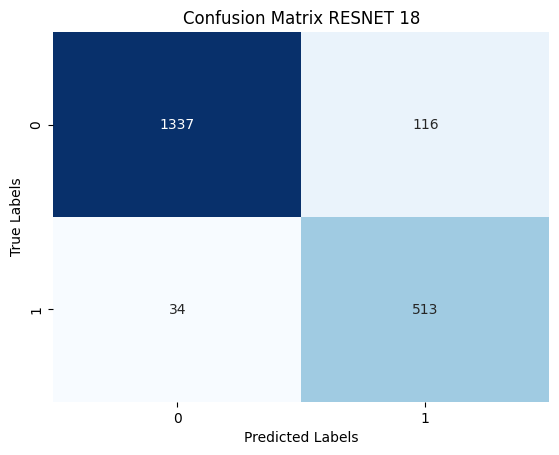

In [21]:
cm = confusion_matrix(y_true_r18.detach().cpu().numpy(), y_pred_r18.detach().cpu().numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix RESNET 18')
plt.show()

## **MODEL RESNET 34**

In [22]:
model_r34 = resnet34()
num_features = model_r34.fc.in_features
model_r34.fc = nn.Linear(num_features, 1)
optimizer_r34 = optim.Adam(model_r34.parameters(), lr=0.0001)

if use_gpu:
    model_r34 = model_r34.cuda()

In [23]:
model_r34 = train_model_resnet(model_r34, dataloders, dataset_sizes, criterion, optimizer_r34)

Epoch 0/9
----------
train Loss: 0.0209 Acc: 0.6070
test Loss: 0.0148 Acc: 0.7725

Epoch 1/9
----------
train Loss: 0.0172 Acc: 0.7200
test Loss: 0.0138 Acc: 0.7880

Epoch 2/9
----------
train Loss: 0.0135 Acc: 0.8070
test Loss: 0.0118 Acc: 0.8330

Epoch 3/9
----------
train Loss: 0.0107 Acc: 0.8543
test Loss: 0.0114 Acc: 0.8410

Epoch 4/9
----------
train Loss: 0.0095 Acc: 0.8707
test Loss: 0.0082 Acc: 0.8855

Epoch 5/9
----------
train Loss: 0.0078 Acc: 0.8990
test Loss: 0.0076 Acc: 0.9045

Epoch 6/9
----------
train Loss: 0.0071 Acc: 0.9067
test Loss: 0.0109 Acc: 0.8650

Epoch 7/9
----------
train Loss: 0.0065 Acc: 0.9177
test Loss: 0.0084 Acc: 0.8910

Epoch 8/9
----------
train Loss: 0.0062 Acc: 0.9160
test Loss: 0.0115 Acc: 0.8535

Epoch 9/9
----------
train Loss: 0.0054 Acc: 0.9337
test Loss: 0.0073 Acc: 0.9075

Training complete in 4m 60s
Best test Acc: 0.907500


In [24]:
y_true_r34, y_pred_r34, inference_r34 = get_report(model_r34, dataloders['test'])
print(classification_report(y_true_r34.detach().cpu().numpy(), y_pred_r34.detach().cpu().numpy(), digits = 4))
print("Inference Time of Model: {}".format(inference_r34))

              precision    recall  f1-score   support

         0.0     0.9818    0.8892    0.9332      1453
         1.0     0.7646    0.9561    0.8497       547

    accuracy                         0.9075      2000
   macro avg     0.8732    0.9227    0.8915      2000
weighted avg     0.9224    0.9075    0.9104      2000

Inference Time of Model: 0.00970210347856794


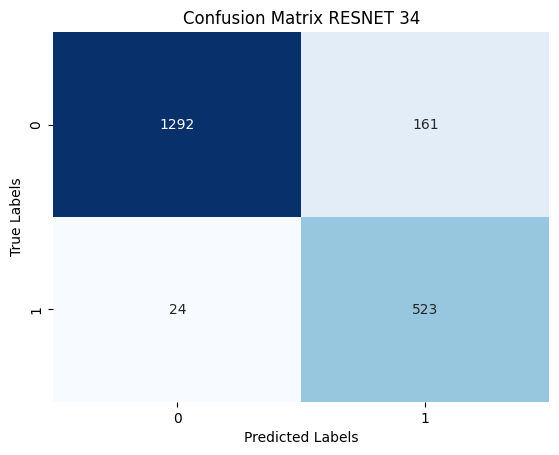

In [25]:
cm = confusion_matrix(y_true_r34.detach().cpu().numpy(), y_pred_r34.detach().cpu().numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix RESNET 34')
plt.show()

## **MODEL GOOGLENET**

In [26]:
def train_model_gnet(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                # backward + optimize only if in training phase
                if phase == 'train':
                    outputs = outputs.logits.squeeze()
                    loss = criterion(outputs, labels.float())
                    loss.backward()
                    optimizer.step()
                else:
                    outputs = outputs.squeeze()
                    loss = criterion(outputs, labels.float())

                # statistics
                preds = (torch.sigmoid(outputs) > 0.5).float()
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
#                 torch.save(state,'./point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
model_gnet = googlenet()
num_ftrs = model_gnet.fc.in_features
model_gnet.fc = nn.Linear(num_ftrs, 1)
optimizer_gnet = optim.Adam(model_gnet.parameters(), lr=0.0001)

if use_gpu:
    model_gnet = model_gnet.cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [28]:
model_gnet = train_model_gnet(model_gnet, dataloders, dataset_sizes, criterion, optimizer_gnet, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0192 Acc: 0.6597
test Loss: 0.0172 Acc: 0.6945

Epoch 1/9
----------
train Loss: 0.0147 Acc: 0.7697
test Loss: 0.0107 Acc: 0.8530

Epoch 2/9
----------
train Loss: 0.0106 Acc: 0.8543
test Loss: 0.0089 Acc: 0.8775

Epoch 3/9
----------
train Loss: 0.0087 Acc: 0.8770
test Loss: 0.0079 Acc: 0.8880

Epoch 4/9
----------
train Loss: 0.0078 Acc: 0.8977
test Loss: 0.0071 Acc: 0.8975

Epoch 5/9
----------
train Loss: 0.0070 Acc: 0.9033
test Loss: 0.0054 Acc: 0.9255

Epoch 6/9
----------
train Loss: 0.0064 Acc: 0.9117
test Loss: 0.0047 Acc: 0.9315

Epoch 7/9
----------
train Loss: 0.0058 Acc: 0.9183
test Loss: 0.0061 Acc: 0.9175

Epoch 8/9
----------
train Loss: 0.0056 Acc: 0.9257
test Loss: 0.0057 Acc: 0.9225

Epoch 9/9
----------
train Loss: 0.0049 Acc: 0.9370
test Loss: 0.0056 Acc: 0.9235

Training complete in 2m 40s
Best test Acc: 0.931500
